In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpl_img
import cv2
import tensorflow as tf 
import pandas as pd
import numpy as np

In [3]:
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

There are pictures of Lego minifigures from different universes (Star Wars, Harry Potter, etc.) in our dataset. Each picture is <br> 512x512 pixels. Figures are photographed from different angles and in different locations.<br>

<h3>Visualizamos algunas imagenes</h3>

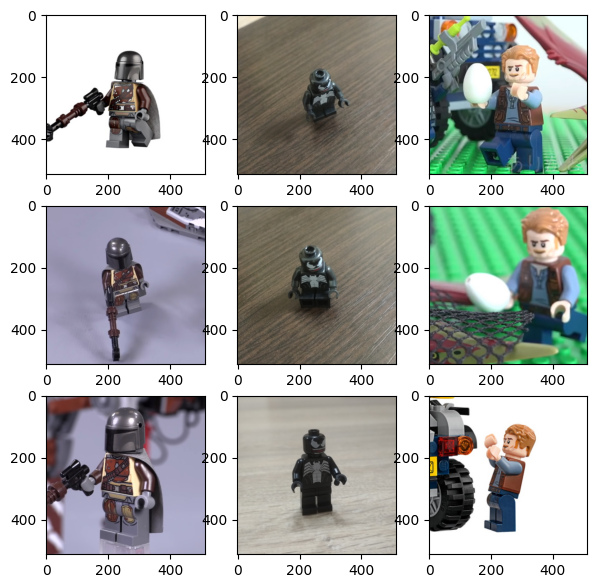

In [4]:
images = [[],[],[]]
index = ['001', '002', '003']

for i in range(3):
    images[i].append(mpl_img.imread('datasets/MINIFIGS/star-wars/0007/' + index[i] + '.jpg'))
    images[i].append(mpl_img.imread('datasets/MINIFIGS/marvel/0002/' + index[i] + '.jpg'))
    images[i].append(mpl_img.imread('datasets/MINIFIGS/jurassic-world/0001/' + index[i] + '.jpg'))

fig, axs = plt.subplots(3,3, figsize=(7,7))

for i in range(3):
    for j in range(3):
        axs[i, j].imshow(images[i][j])

importamos los datos (contienen las direcciones de las imagenes)

In [5]:
train_set = pd.read_csv('datasets/MINIFIGS/index.csv')
train_set

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1
...,...,...
366,star-wars/0017/006.jpg,38
367,star-wars/0017/007.jpg,38
368,star-wars/0017/008.jpg,38
369,star-wars/0017/009.jpg,38


In [6]:
validation_set = pd.read_csv('datasets/MINIFIGS/test.csv')
validation_set

,path,class_id
0,test/001.jpg,32
1,test/002.jpg,32
2,test/003.jpg,32
3,test/004.jpg,32
4,test/005.jpg,1
...,...,...
74,test/075.jpg,37
75,test/076.jpg,37
76,test/077.jpg,38
77,test/078.jpg,38


 we will take a pre-trained DenceNet model, but change the last layer in it and also add our own output layer, so this model will classify what we need, in our case, Lego minifigures.

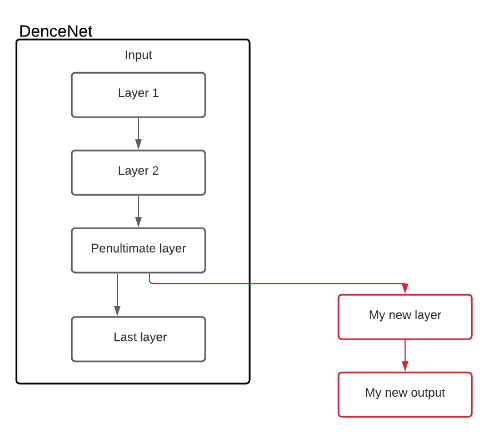

Keras <b>Applications</b> are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

In [7]:
# take pretrained DenseNet
base_model = tf.keras.applications.DenseNet121()

# Create new Dropout layer and sent there penultimate output from DenseNet 
#"from tensorflow.keras.layers import Dropout, Dense"
my_layer = Dropout(0.5)(base_model.layers[-2].output)

# Count the number of unique classes in dataset 
number_of_classes = len(train_set['class_id'].unique())

# Create new Dense layer and sent there output from Dropout layer
# Note that in this Dense layer is "number_of_classes" neuron because 
# we have "number_of_classes" classes
my_outputs = Dense(number_of_classes, activation="softmax")(my_layer)

#"from tensorflow.keras.models import  Model"
model = Model(base_model.input, my_outputs) 

<b>Note:</b> last Dense layer has "number_of_classes" neuron because we have "number_of_classes" classes, so the output from our model will be a vector with "number_of_classes" float numbers and the answer will be the index of the max element.

Now we must compile our model.

In [8]:
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer= Adam(0.0001), 
              metrics=['accuracy'])

The neural network accepts an image as input in the form of pixel values, so the code below simply transforms the images from the training and validation set into arrays of numbers and saves them.

In [9]:

X_train = np.zeros((train_set.shape[0], 224, 224, 3))

for i in range(train_set.shape[0]):
    image = cv2.imread('datasets/MINIFIGS/' + train_set["path"].values[i])
    image = cv2.resize(image, dsize=(224, 224)) # resize in case if image was not 512x512 pixels
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_train[i] = image/255

Y_train = np.array(train_set["class_id"])-1

#===

X_valid = np.zeros((validation_set.shape[0], 224, 224, 3))

for i in range(validation_set.shape[0]):
    image = cv2.imread('datasets/MINIFIGS/' + validation_set["path"].values[i])
    image = cv2.resize(image, dsize=(224, 224))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_valid[i] = image/255

Y_valid = np.array(validation_set["class_id"])-1

In [10]:
# Resize training images
X_train_resized = np.zeros((train_set.shape[0], 224, 224, 3))

for i in range(train_set.shape[0]):
    image = cv2.imread('datasets/MINIFIGS/' + train_set["path"].values[i])
    image = cv2.resize(image, dsize=(224, 224))  # Resize to match model input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_train_resized[i] = image/255

# Resize validation images
X_valid_resized = np.zeros((validation_set.shape[0], 224, 224, 3))

for i in range(validation_set.shape[0]):
    image = cv2.imread('datasets/MINIFIGS/' + validation_set["path"].values[i])
    image = cv2.resize(image, dsize=(224, 224))  # Resize to match model input size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    X_valid_resized[i] = image/255

This is lables in train set. <br>

Note: Labels must be from 0 to n, but in our dataset labels from 1 to n, <br>
so above wen we save Y_valid and Y_train we subtract 1. I draw your attention to this, <br>
because in the future when we receive the answer class we will have to add 1 for the right answer.<br>

In [11]:
Y_train

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 14,
       14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16,
       16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21,
       21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 23, 23

Before training the model, let's create the checkpoint for the model. It's mean that we will save only the best model.<br> We do this because there may be a situation when, for example, we train the model for 50 epochs, but the best result was at 43 epochs,<br> so if we do not save it, we will lose the best result and get only the final result from 50 epochs.<br>

We will name our best model just "model.h5".<br> We will choose the best model by value accuracy score (monitor="val_accuracy").

In [12]:
checkpoint = ModelCheckpoint(filepath='model.h5', monitor="val_accuracy", save_best_only=True, verbose=1)

Now let's train our model! <br>

Note: the function fit() has a parameter "callbacks" where we will pass our checkpoint.

In [13]:
# Use resized data for training
model.fit(
    X_train_resized, 
    Y_train, 
    epochs=30, 
    validation_data=(X_valid_resized, Y_valid), 
    shuffle=True, 
    batch_size=4, 
    callbacks=checkpoint
)


Epoch 1/30
93/93 [==============================] - ETA: 0s - loss: 3.9288 - accuracy: 0.0620
Epoch 1: val_accuracy improved from -inf to 0.31646, saving model to model.h5
93/93 [==============================] - 435s 4s/step - loss: 3.9288 - accuracy: 0.0620 - val_loss: 2.5854 - val_accuracy: 0.3165
Epoch 2/30
93/93 [==============================] - ETA: 0s - loss: 2.3588 - accuracy: 0.3369
Epoch 2: val_accuracy improved from 0.31646 to 0.70886, saving model to model.h5
93/93 [==============================] - 342s 4s/step - loss: 2.3588 - accuracy: 0.3369 - val_loss: 1.3503 - val_accuracy: 0.7089
Epoch 3/30
93/93 [==============================] - ETA: 0s - loss: 1.4544 - accuracy: 0.6577
Epoch 3: val_accuracy improved from 0.70886 to 0.86076, saving model to model.h5
93/93 [==============================] - 396s 4s/step - loss: 1.4544 - accuracy: 0.6577 - val_loss: 0.8910 - val_accuracy: 0.8608
Epoch 4/30
93/93 [==============================] - ETA: 0s - loss: 0.9295 - accuracy: 0

KeyboardInterrupt: 